# Homework 2
Using the same dataset with homework 1 and performing 2 tasks:

Task 1: instead of tf-idf, using word2vect for word embedding

Task 2: instead of logistic regession, using 2 layer neural network



## 1 - Packages ##

First, import all the needed packages

In [36]:
# libraries for dataset preparation, feature engineering


import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Copy of dnn_app_utils_v2

dnn_app_utils provides the functions implemented in the "Building your Deep Neural Network: Step by Step" assignment to this notebook.

In [0]:

import numpy as np
import matplotlib.pyplot as plt
import h5py


def sigmoid(Z):
    print(Z.shape)
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters     


def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


## 2 - Dataset preparation ##


The dataset ("news_dataset.csv") containing a set of Vietnamses news labeled as doi_song, khoa_hoc, kinh_doanh




In [0]:
# Uncomment this part when using Google Colabotatory
# 1. Code to read csv file into Google colaboratory
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1.1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 1.2. Get the file
data_train = drive.CreateFile({'id':'1_GQgqF2ywAxlLAazDgWfQ51VgV4QponP'}) # replace the id with id of file you want to access
data_train.GetContentFile('news_dataset.csv')  

df = pd.read_csv('news_dataset.csv', header = 0) 

label = np.array(df.iloc[1:, 1])


In [39]:
# The dataframe has two columns, text and label 
df.head()

text     label
0  ﻿Có thể vì quá bận rộn  nhút nhát hoặc quá buồ...  doi_song
1  ﻿ Xoài cát cá trê Cho xoài ướp vào trộn đều vớ...  doi_song
2  ﻿Chuyện nghe có vẻ nghịch lý lại là sự thật 10...  doi_song
3  ﻿Thỉnh thoảng để cha mẹ chú ý đến mình hay trá...  doi_song
4  ﻿Chim muốn bay đường dài đều phải biết lượn. C...  doi_song

In [40]:
size_doi_song = df[df['label'] == "doi_song"].shape[0]
size_khoa_hoc = df[df['label'] == "khoa_hoc"].shape[0]
size_kinh_doanh = df[df['label'] == "kinh_doanh"].shape[0]
print('Number of doi song documents: %s' %size_doi_song)
print('Number of khoa hoc documents: %s' %size_khoa_hoc)
print('Number of kinh doanh documents: %s' %size_kinh_doanh)

Number of doi song documents: 200
Number of khoa hoc documents: 200
Number of kinh doanh documents: 200


In [41]:
# an example of a doi_song news
df['text'][4]

'\ufeffChim muốn bay đường dài đều phải biết lượn. Chúng phần lớn có đôi cánh rộng và thân hình uyển chuyển  sau khi ra sức vỗ cánh sẽ thư giãn xòe rộng đôi cánh  chậm rãi bay lượn về nơi chân trời. Vì vậy  trong hành trình thiên di  nhìn thì tựa như chúng liên tục vỗ cánh bay  nhưng thực ra phần lớn thời gian chúng đều tận dụng sức nâng của không khí để vừa tiêu trừ căng thẳng  vừa tích trữ sức lực  chuẩn bị cho lần vỗ cánh khác. Người thành công trong dựng nghiệp lớn đều biết cách thư giãn. Họ phần lớn đều có tấm lòng rộng rãi và tính tình cởi mở. Sau những vất vả bận rộn  họ thả lỏng bản thân  tận hưởng sự yên tĩnh  lặng lẽ quan sát sự phát triển của thế giới bên ngoài  tính toán bước phát triển ở tương lai  khôi phục nguyên khí và xung lực.  '

Next, we will split the dataset into training and test sets so that we can train and test classifier. Also, we will encode our target column so that it can be used in our model.

In [42]:
# split the dataset into training and test datasets 
train_x, test_x, train_y, test_y = model_selection.train_test_split(df['text'], df['label'])


# label encode the target variable, encode labels to 0 , 1, or 2
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)
print('["doi_song", "khoa_hoc", "kinh_doanh"] labels corresponds to %s labels' %encoder.transform(["doi_song", "khoa_hoc", "kinh_doanh"]))

size_doi_song_test = test_y[test_y==0].shape[0]
size_khoa_hoc_test = test_y[test_y==1].shape[0]
size_kinh_doanh_test = test_y[test_y==2].shape[0]
print('Number of doi song documents in test set: %s' %size_doi_song)
print('Number of khoa hoc documents in test set: %s' %size_khoa_hoc)
print('Number of kinh doanh documents in test set: %s' %size_kinh_doanh)

["doi_song", "khoa_hoc", "kinh_doanh"] labels corresponds to [0 1 2] labels
Number of doi song documents in test set: 200
Number of khoa hoc documents in test set: 200
Number of kinh doanh documents in test set: 200


The next step is the feature engineering step. In this step, raw text data will be transformed into feature vectors and new features will be created using the existing dataset.

### Word Embeddings

In [43]:
!pip install pyvi
from pyvi import ViTokenizer
from gensim.models.word2vec import Word2Vec
from keras.preprocessing import sequence
import gensim

A word embedding is a form of representing words and documents using a dense vector representation. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used. Word embeddings can be trained using the input corpus itself or can be generated using pre-trained word embeddings such as Glove, FastText, and Word2Vec. Any one of them can be downloaded and used as transfer learning.

Loading a pretrained word embeddings - based on Vietnam wikipedia.

The word embeddings are trained with gensim - a library for training Word2Vec.

In [0]:
vi_pretrained_word_embedding = drive.CreateFile({'id':'1Uyf5B-axONXpRcaDVgJ8_XCo178iCN4I'}) # replace the id with id of file you want to access
vi_pretrained_word_embedding.GetContentFile('vi.bin')  

w2vmodel = Word2Vec.load('vi.bin').wv

In [45]:
w2vmodel.most_similar('tin_tức')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('thông_tin', 0.6357954144477844),
 ('phóng_viên', 0.6156644821166992),
 ('báo_cáo', 0.6109340786933899),
 ('bình_luận', 0.6045681238174438),
 ('báo_chí', 0.6012976169586182),
 ('biên_tập_viên', 0.5868688821792603),
 ('thời_sự', 0.5609147548675537),
 ('trực_tuyến', 0.5557072162628174),
 ('phóng_sự', 0.5530217885971069),
 ('diễn_đàn', 0.543127179145813)]

In [46]:
emb_dim = len(w2vmodel['chính_trị'])
print('Length of a word vector: %s' %emb_dim)

Length of a word vector: 100


In [0]:
# helper functions

# Use Pyvi, a popular tokenizer for Vietnamese for tokenizing a line
def tokenlizer(line):
  return ViTokenizer.tokenize(line.lower())

# Apply tokenizer for a list of lines
def read_input(input_data):
    for line in input_data:
        yield tokenlizer(line)
        
# Make feature vector for a line using pretrained word to vec  model
def make_feature_vec(words, w2vmodel):
    
    nwords = 0

    feature_vec = np.zeros((emb_dim*len(words),),dtype="float32") 
    out_of_vocab_word = np.zeros((emb_dim,),dtype="float32")

    for word in words:
        nwords = nwords + 1.
        if word in w2vmodel.vocab:
          feature_vec = np.concatenate((feature_vec,w2vmodel.wv[word]), axis=None)
        else:
          feature_vec = np.concatenate((feature_vec,out_of_vocab_word), axis=None)

    return feature_vec.T

 # Zero padding for for sentences which have the length smaller than max length
def padding(X_vectors, max_lengh=200000):
    features_matrix = [np.zeros((max_lengh,),dtype="float32") for _ in range(len(X_vectors))]
    for i in range (len(X_vectors)):
      feature_vec = np.empty(max_lengh)
      if len(X_vectors[i]) < max_lengh:
        feature_vec[:len(X_vectors[i])] = X_vectors[i]
        feature_vec[len(X_vectors[i]):] = np.zeros((max_lengh - len(X_vectors[i]),),dtype="float32") 
      elif len(X_vectors[i]) < max_lengh:
        feature_vec = X_vectors[i][:max_lengh]
      else: feature_vec = X_vectors[i][:max_lengh]
      features_matrix[i] = feature_vec
    return features_matrix

def extract_features(X_data, w2vmodel):
    features_matrix = [np.zeros((emb_dim,),dtype="float32") for _ in range(len(X_data))]
    train_labels = np.zeros(len(X_data))
    
    for i in range (len(X_data)):
        if (len(X_data[i]) > 1):
            words = gensim.utils.simple_preprocess(X_data[i], deacc=False, min_len=1, max_len=100)
            feature_vector =  make_feature_vec(words, w2vmodel)
            features_matrix[i] = feature_vector
    
    return features_matrix
        


In [48]:

train_x_tokens = list(read_input(train_x))
test_x_tokens = list(read_input(test_x))
print(np.shape(train_x_tokens))

(450,)


In [49]:
# calculate the word2vec value for training set and test set
train_x_vectors =  np.array(padding(extract_features(train_x_tokens, w2vmodel)))
test_x_vectors =  np.array(padding(extract_features(test_x_tokens, w2vmodel)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [50]:
# Getting transformed training and testing dataset
print('Number of training documents: %s' %str(train_x_vectors.shape[0]))
print('Number of testing documents: %s' %str(test_x_vectors.shape[0]))
print('Number of features of each document: %s' %str(train_x_vectors.shape[1]))
print('train_x_vectors shape: %s' %str(train_x_vectors.shape))
print('train_y shape: %s' %str(train_y.shape))
print('test_x_vectors shape: %s' %str(test_x_vectors.shape))
print('test_y shape: %s' %str(test_y.shape))

Number of training documents: 450
Number of testing documents: 150
Number of features of each document: 200000
train_x_vectors shape: (450, 200000)
train_y shape: (450,)
test_x_vectors shape: (150, 200000)
test_y shape: (150,)


Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs.

**Exercise:**: For convenience, you should now transpose the training and testing numpy-array, and expand the shape of the lable arrays in the axis=0 position.

After this, our training (and test) dataset is a numpy-array where each column represents a document vector. There should be the number of training documents (respectively the number of testing documents) as the number of columns.

In [0]:
### START CODE HERE ###
train_y = np.expand_dims(train_y, axis=0)
test_y = np.expand_dims(test_y, axis=0)

# for convenience in this exercise, we also use toarray() to convert sparse to dense matrix 
train_x_vectors =  train_x_vectors.T
test_x_vectors =  test_x_vectors.T
### END CODE HERE ###

In [52]:
# New shape 
print('train_x_vectors shape: %s' %str(train_x_vectors.shape))
print('train_y shape: %s' %str(train_y.shape))
print('test_x_vectors shape: %s' %str(test_x_vectors.shape))
print('test_y shape: %s' %str(test_y.shape))

train_x_vectors shape: (200000, 450)
train_y shape: (1, 450)
test_x_vectors shape: (200000, 150)
test_y shape: (1, 150)


## 3 - General Architecture of the learning algorithm ##

It's time to design a simple algorithm to distinguish politics-society news from other news.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

**The below image is an analogy of the network architecture of an image classifier to a text classifier.**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

## 4 - Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.

### 4.1 - Helper functions

**Exercise**: Using your code from "Python Basics", implement `sigmoid()`. As you've seen in the figure above, you need to compute $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ to make predictions. Use np.exp().

In [0]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1/(1+np.exp(-z))
    ### END CODE HERE ###
    
    return s

In [54]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


**Expected Output**: 

<table>
  <tr>
    <td>**sigmoid([0, 2])**</td>
    <td> [ 0.5         0.88079708]</td> 
  </tr>
</table>

### 4.2 - Initializing parameters

**Exercise:** Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [0]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros((dim,1))
    b = 0.
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [56]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0.0


**Expected Output**: 


<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

### 4.3 - Forward and Backward propagation

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

**Exercise:** Implement a function `propagate()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [0]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = np.float(X.shape[1])
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T,X) + b)                                    # compute activation
    cost = -(1/m) * (np.sum((Y*np.log(A))+ ((1-Y)*np.log(1-A))))     # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (1/m)*(np.dot(X,(A-Y).T))
    db = (1/m)*(np.sum(A-Y))
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [58]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


**Expected Output**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
      <td> [[ 0.99845601]
     [ 2.39507239]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

### 4.4 - Optimization
- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.

**Exercise:** Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [0]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector, of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w,b,X,Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate*dw
        b = b - learning_rate*db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [60]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


**Expected Output**: 

<table style="width:40%">
    <tr>
       <td> **w** </td>
       <td>[[ 0.19033591] [ 0.12259159]] </td>
    </tr>
    <tr>
       <td> **b** </td>
       <td> 1.92535983008 </td>
    </tr>
    <tr>
       <td> **dw** </td>
       <td> [[ 0.67752042] [ 1.41625495]] </td>
    </tr>
    <tr>
       <td> **db** </td>
       <td> 0.219194504541 </td>
    </tr>
</table>

**Exercise:** The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function. There are two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this). 

In [0]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m), dtype=np.int)
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a news being present
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T,X) + b)
    ### END CODE HERE ###
    
    for i in range(A.shape[1]):
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        if (A[0][i] > 0.5):
            Y_prediction[0][i] = 1
        else:
            Y_prediction[0][i] = 0
        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction, A

In [62]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)[0]))

predictions = [[1 1 0]]


**Expected Output**: 

<table style="width:30%">
    <tr>
         <td>
             **predictions**
         </td>
          <td>
            [[ 1.  1.  0.]]
         </td>  
   </tr>

</table>


<font color='blue'>
**What to remember:**
You've implemented several functions that:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient 
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

## 5 - Merge all functions into a model ##

You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

**Exercise:** Implement the model function. Use the following notation:
    - Y_prediction_test for your predictions on the test set
    - Y_prediction_train for your predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [0]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w,b,X_test)[0]
    Y_prediction_train = predict(w,b,X_train)[0]

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Run the following cell to train your model.

In [64]:
print("Classification result of recognizing doi_song's news")
temp_train_y = train_y.copy()
temp_test_y = test_y.copy()
temp_train_y[temp_train_y != 0 ] = 1
temp_test_y[temp_test_y != 0 ] = 1

print(temp_test_y[temp_test_y == 1].shape[0])
print(temp_test_y[temp_test_y == 0].shape[0])

d = model(train_x_vectors, temp_train_y, test_x_vectors, temp_test_y, num_iterations = 3000, learning_rate = .5, print_cost = False)

Classification result of recognizing doi_song's news
99
51


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


train accuracy: 100.0 %
test accuracy: 80.66666666666667 %


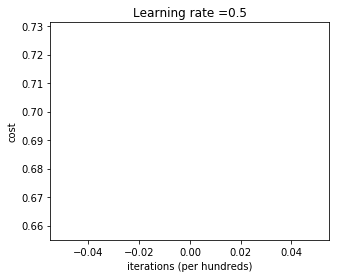

In [65]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

In [66]:
print("Classification result of recognizing khoa_hoc's news")
temp_train_y = train_y.copy()
temp_test_y = test_y.copy()
temp_train_y[temp_train_y != 1 ] = 0
temp_test_y[temp_test_y != 1 ] = 0

print(temp_test_y[temp_test_y == 1].shape[0])
print(temp_test_y[temp_test_y == 0].shape[0])

d = model(train_x_vectors, temp_train_y, test_x_vectors, temp_test_y, num_iterations = 3000, learning_rate = .5, print_cost = False)

Classification result of recognizing khoa_hoc's news
44
106


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


train accuracy: 100.0 %
test accuracy: 80.0 %


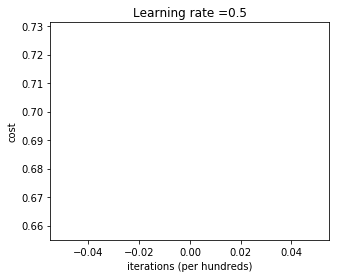

In [67]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

In [68]:
print("Classification result of recognizing kinh_doanh's news")
temp_train_y = train_y.copy()
temp_test_y = test_y.copy()
temp_train_y[temp_train_y != 2 ] = 1
temp_test_y[temp_test_y != 2 ] = 1

print(temp_test_y[temp_test_y == 1].shape[0])
print(temp_test_y[temp_test_y == 2].shape[0])

d = model(train_x_vectors, temp_train_y, test_x_vectors, temp_test_y, num_iterations = 3000, learning_rate = .5, print_cost = False)

Classification result of recognizing kinh_doanh's news
95
55


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


train accuracy: 67.77777777777777 %
test accuracy: 63.333333333333336 %


Let's also plot the cost function and the gradients.

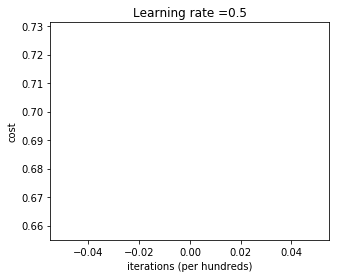

In [69]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

Conclusion: word2vec + logistic regression has worst result than tf-idf + logistic regression


Here is the result of tf-idf + logistic regression:

Classification result of recognizing doi_song's news
train accuracy: 99.33333333333333 %
test accuracy: 93.33333333333333 %

Classification result of recognizing khoa_hoc's news
train accuracy: 100.0 %
test accuracy: 90.66666666666667 %

Classification result of recognizing kinh_doanh's news
train accuracy: 66.88888888888889 %
test accuracy: 66.0 %


Here is the result of word2vec + logistic regression:

Classification result of recognizing doi_song's news
train accuracy: 100.0 %
test accuracy: 80.66666666666667 %

Classification result of recognizing khoa_hoc's news
train accuracy: 100.0 %
test accuracy: 80.0 %

Classification result of recognizing kinh_doanh's news
train accuracy: 67.77777777777777 %
test accuracy: 63.333333333333336 %

The result on training data is the same but the result on the test data of tf-idf  + logistic regressiion is better. It seem that word2vec + logistic regression overfits the training set.

# Word2Vec + 2-layer neural network


In [0]:
### CONSTANTS ###
layers_dims = [200000, 20, 7, 5, 1] #  4-layer model

In [0]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.1, num_iterations = 2000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X,parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL,Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL,Y,caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters,grads,learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Train and test for detect doi_song's news

In [0]:
temp_train_y = train_y.copy()
temp_test_y = test_y.copy()
temp_train_y[temp_train_y != 0 ] = 1
temp_test_y[temp_test_y != 0 ] = 1

#parameters = L_layer_model(train_x_vectors, temp_train_y, layers_dims, num_iterations = 500, print_cost = True)

In [73]:
pred_train = predict(train_x_vectors, temp_train_y, parameters)

NameError: ignored

In [0]:
pred_test = predict(test_x_vectors, temp_test_y, parameters)

Train and test for khoa_hoc's news

In [0]:
temp_train_y = train_y.copy()
temp_test_y = test_y.copy()
temp_train_y[temp_train_y != 1 ] = 0
temp_test_y[temp_test_y != 1 ] = 0

parameters = L_layer_model(train_x_vectors, temp_train_y, layers_dims, num_iterations = 500, print_cost = True)

In [0]:
pred_train = predict(train_x_vectors, temp_train_y, parameters)

In [0]:
pred_test = predict(test_x_vectors, temp_test_y, parameters)

Train and test for kinh_doanh's news

In [0]:
temp_train_y = train_y.copy()
temp_test_y = test_y.copy()
temp_train_y[temp_train_y != 2 ] = 1
temp_test_y[temp_test_y != 2 ] = 1

parameters = L_layer_model(train_x_vectors, temp_train_y, layers_dims, num_iterations = 500, print_cost = True)

In [0]:
pred_train = predict(train_x_vectors, temp_train_y, parameters)

In [0]:
pred_test = predict(test_x_vectors, temp_test_y, parameters)